# Building a Machine Learning Pipeline to Predict Whether an Audio File Was Recorded Indoors or Outdoors

# 1. Problem formulation

The MLEnd London Sounds dataset contains short audio recordings of various locations around London. Each sample is described by the 5 attributes:

| Attribute   | Description                         |
| ----------- | ------------------------------------|
| Audio       | The audio data of each .wav sample |
| area        | The location descriptor (6 unique areas) |
| spot        | The specific location within the area (6 for each area) |
| in_out      | Whether the sample was recorded indoors (17 unique) or outdoors (19 unique) |
| participant | The unique identifier assigned to each participant |

A supervised machine learning pipeline will be built that takes an audio recording as the input and predicts whether it was recorded indoors or outdoors.

The ability to predict whether an audio recording is indoors or outdoors has many potential applications. For example, 999 call handlers will have a better idea of the help they may be required to provide and the location if they are unable to determine from the call. Another application is for audio software to intelligently adapt equaliser settings to better match the external audio environment.

# 2. Machine Learning pipeline

The pipeline stages for building the model are as follows:

    audio recordings -> transformation -> model training -> predicted labels

- The pipeline input is the audio recordings.
- The model inputs are the features extracted from the audio files in the transformation stage (described in section 4). These features are the predictors to be used in the model.
- The pipeline output will be a binary label, `y`, with a value of `1` for indoors and a value of `0` for outdoors.

Once the model has been built, a pipeline can be created that takes an audio recording and uses the trained model to predict whether it was recorded indoors or outdoors:

    audio recording -> transformation -> trained model -> predicted label


# 3. Transformation stage

Transformation is used to in order to obtain a more useful and usable representation of the data. Since each audio file consists of discrete signals according to the sample rate, there will be too many samples to use directly in a model. Instead, several features can be extracted from the audio files to reduce the dimensionalilty of the data. These features will be:

1. Mel-frequency cepstral coefficients (MFCCs)
2. Spectral centroid
3. Spectral rolloff
4. Zero crossing rate
5. Root mean square (RMS)

Together, these attributes are able to describe a wide variety of the audio characteristics that are useful in differentiating between indoor and audio recordings. The MFCCs consist of 20 different audio features, so there will be a total of 24 extracted features for each audio sample. For each feature, the average is taken over the length of the audio recording so there are only single values to describe each feature.

The output of the transformation stage is then used as the predictors for the model.

# 4. Modelling

The random forest technique has been chosen to classify the samples. This classification technique is able to take continuous data as its input, whilst also being suitable in predicting a binary outcome (indoors, outdoors). The random forest classifier is an ensemble model which reduces the risk of overfitting exhibited by decision trees by training many trees and then averaging the predictions. Another benefit is there is no need to normalise the data prior to using the random forest due to it being a tree based model. Finally, the model is able to deal with noisy data.

# 5. Methodology

The dataset will be split into training and testing datasets. 70% of the samples will be for training and 30% will be for testing.

The *k*-fold cross-validation technique will be used to select the best hyperparameters to use for the random forest classifier. The *k* value used will be 5. So the training dataset is split into 5 folds, where each fold will be used once for validation and the remaining (k-1) folds are used as the training dataset. The best classifier is the one which achieves the highest performance according to the validation folds. The model is then fit on the original training dataset using the best hyperparameter settings. Finally, the models performance is assessed by computing its accuracy on the test dataset.

# 6. Dataset

The required Python libraries are loaded and Google Drive is mounted to access the dataset.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import shutil, glob
from tqdm import tqdm

import IPython.display as ipd
import librosa

In [ ]:
sample_path = '/content/drive/MyDrive/Colab Notebooks/ML/Mini Project/Data/*.wav'
files = glob.glob(sample_path)
print('There are', len(files), 'audio files in the dataset.')

There are 2498 audio files in the dataset.


The audio files `0033.wav` and `2206.wav` have been removed from the original dataset of 2500 samples since these were known to be faulty "empty" audio files. The first and last 5 samples and their attributes are shown below.

In [ ]:
MLENDLS_df = pd.read_csv('./MLEndLS.csv').set_index('file_id')
MLENDLS_df

,area,spot,in_out,Participant
file_id,,,,
0001.wav,british,street,outdoor,S151
0002.wav,kensington,dinosaur,indoor,S127
0003.wav,campus,square,outdoor,S18
0004.wav,kensington,hintze,indoor,S179
0005.wav,campus,square,outdoor,S176
...,...,...,...,...
2496.wav,westend,trafalgar,outdoor,S151
2497.wav,campus,square,outdoor,S6
2498.wav,westend,national,indoor,S96


An example audio file:

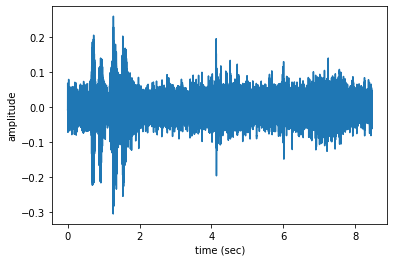


These are the attributes associated with this audio file:


area            campus
spot            square
in_out         outdoor
Participant       S138
Name: 2103.wav, dtype: object

In [ ]:
n = 3
fs = None
x, fs = librosa.load(files[n],sr=fs)
t = np.arange(len(x))/fs
plt.plot(t,x)
plt.xlabel('time (sec)')
plt.ylabel('amplitude')
plt.show()
print('')
display(ipd.Audio(files[n]))
print('\nThese are the attributes associated with this audio file:')
MLENDLS_df.loc[files[n].split('/')[-1]]

In [ ]:
in_out_count = MLENDLS_df.groupby('in_out')['area'].count()
print('The number of indoor recordings is {}'.format(in_out_count[0]))
print('The number of outdoor recordings is {}'.format(in_out_count[1]))

The number of indoor recordings is 1181
The number of outdoor recordings is 1319


A separate small dataset of 10 samples will be reserved for the demonstration of the model.

In [ ]:
for _ in range(10):
  n = np.random.randint(2000)
  shutil.move(files[n], '/content/drive/MyDrive/Colab Notebooks/ML/Mini Project/Data/Reserved')

In [ ]:
files = glob.glob(sample_path)
print('There are now', len(files), 'files in the dataset')

There are now 2488 files in the dataset


In [ ]:
reserved_sample_path = '/content/drive/MyDrive/Colab Notebooks/ML/Mini Project/Data/Reserved/*.wav'
reserved_files = glob.glob(reserved_sample_path)
print(len(reserved_files), 'audio files have been reserved for demonstration.')

10 audio files have been reserved for demonstration.


A function is defined below which extracts the audio features and labels from each file it is provided with.

In [ ]:
def getXy(files, labels_file):
  X,y = [],[]
  for file in tqdm(files):
    fileID = file.split('/')[-1]
    yi = labels_file.loc[fileID]['in_out']=='indoor'

    fs = None
    x, fs = librosa.load(file,sr=fs)

    mfccs = np.mean(librosa.feature.mfcc(x, sr=fs, n_mfcc=20).T, axis=0)
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(x, sr=fs))
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(x, sr=fs))
    rms = np.mean(librosa.feature.rms(x))
    zcrs = np.mean(librosa.feature.zero_crossing_rate(x))

    xi = np.append(mfccs, [spectral_centroid, spectral_rolloff, rms, zcrs])
    X.append(xi)
    y.append(yi)

  return np.array(X),np.array(y)

In [ ]:
X,y = getXy(files, labels_file=MLENDLS_df)

100%|██████████| 2488/2488 [10:19<00:00,  4.01it/s]


The dataset is split into training (70%) and testing (30%) datasets.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

In [ ]:
print('The shape of X is', X.shape)
print('The shape of y is', y.shape)
print('The first 20 labels are:', y[:20])

The shape of X is (2488, 24)
The shape of y is (2488,)
The first 20 labels are: [False  True False False False  True False  True False False  True  True
 False False False  True  True  True  True False]


# 7. Results

The random forest classifier is now trained and the best hyperparameters are selected according to the results of the cross-validation:

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

parameters = {'n_estimators': [100, 200, 400],'max_features':[4, 7, 10, 15, 24]}

rfc = RandomForestClassifier()
rfc_cv = GridSearchCV(rfc, parameters, cv=5)
rfc_cv.fit(X_train, y_train)

print('The best hyperparameters to use are: {}.'.format(rfc_cv.best_estimator_))
print('Training dataset accuracy: {:.2f}'.format(rfc_cv.score(X_train, y_train)))
print('Test dataset accuracy: {:.2f}.'.format(rfc_cv.score(X_test, y_test)))

The best hyperparameters to use are: RandomForestClassifier(max_features=10, n_estimators=400).
Training dataset accuracy: 1.00
Test dataset accuracy: 0.75.


The model is now provided with an unseen audio segment taken at random from the demonstration dataset.

In [ ]:
n = np.random.randint(10)
fs = None
x, fs = librosa.load(reserved_files[n],sr=fs)
file_name = reserved_files[n].split('/')[-1]
print(file_name)
in_or_out = MLENDLS_df[MLENDLS_df.index == file_name]['in_out'][0]
print('The in_out attribute for this file is: %s\n' % (in_or_out))

display(ipd.Audio(reserved_files[n]))

0538.wav
The in_out attribute for this file is: outdoor



A function is defined below which takes a single audio file as an input and outputs a prediction of whether the audio was recorded indoors or outdoors.

In [ ]:
def PredictIndoorsOrOutdoors(file):
  mfccs = np.mean(librosa.feature.mfcc(file, sr=fs, n_mfcc=20).T, axis=0)
  spectral_centroid = np.mean(librosa.feature.spectral_centroid(file, sr=fs))
  spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(file, sr=fs))
  rms = np.mean(librosa.feature.rms(file))
  zcrs = np.mean(librosa.feature.zero_crossing_rate(file))

  X_sample = np.append(mfccs, [spectral_centroid, spectral_rolloff, rms, zcrs])

  prediction = rfc_cv.predict(X_sample.reshape(1,-1))

  if prediction == True:
    print('The prediction for the file, %s, is: indoors' % (file_name))
  else:
    print('The prediction for the file, %s, is outdoors' % (file_name))

  return

In [ ]:
PredictIndoorsOrOutdoors(x)

The prediction for the file, 0538.wav, is outdoors


The model correctly predicted from the previously unseen audio sample, that it was recorded outdoors.

# 8. Conclusions

The training dataset accuracy of 1.00 means a classifier was able to perfectly fit to the training dataset, which is not uncommon for a random forest classifier. However, the accuracy on the test dataset was lower, at 0.75. Since the prediction is binary, an accuracy of more than 0.5 means the model outperforms a chance selection of indoors/outdoors. However, here the model is still incorrect 25% of the time. The use of *k*-fold cross-validation should have reduced overfitting to the training dataset, however there are still further parameters that could have been used for tuning such as tree depth and maximum number of nodes. Increasing the number of estimators may also help improve accuracy subject to diminishing returns. Finally, the use of other features to complement or replace the current features should be explored which may prove to be more useful predictors for the model.

